In [4]:
# 1. Install missing libraries
!pip install sentence-transformers python-dotenv google-generativeai

In [5]:
import pandas as pd
from sentence_transformers import SentenceTransformer
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
import os
import google.generativeai as genai
from dotenv import load_dotenv
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import google.generativeai as genai
import os

In [6]:
from google.colab import userdata

load_dotenv()

GOOGLE_API_KEY = userdata.get('GEMINI_API_KEY')

df = pd.read_csv("clean_customer_churn_dataset.csv")

# Load model once (fast)
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

def gemini_reply(prompt):
    genai.configure(api_key=GOOGLE_API_KEY)
    model = genai.GenerativeModel("gemini-2.5-flash")
    response = model.generate_content(prompt)
    return response.text

def get_embedding(text: str) -> np.ndarray:
    """
    Returns a vector embedding for the input string
    using all-MiniLM-L6-v2.
    """
    embedding = model.encode(text, convert_to_numpy=True)
    return embedding

df["customer_feedback(vector)"] = df["customer_feedback"].apply(get_embedding)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

#EDA

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372 entries, 0 to 1371
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customer_id                1372 non-null   float64
 1   age                        1372 non-null   float64
 2   gender                     1372 non-null   object 
 3   subscription_type          1372 non-null   object 
 4   tenure_months              1372 non-null   float64
 5   monthly_spend              1372 non-null   float64
 6   support_tickets            1372 non-null   float64
 7   avg_session_time           1372 non-null   float64
 8   customer_feedback          1372 non-null   object 
 9   churn                      1372 non-null   float64
 10  customer_feedback(vector)  1372 non-null   object 
dtypes: float64(7), object(4)
memory usage: 118.0+ KB
Summary Stats:
        customer_id          age  tenure_months  monthly_spend  \
count  1.372000e+03  1372.0000

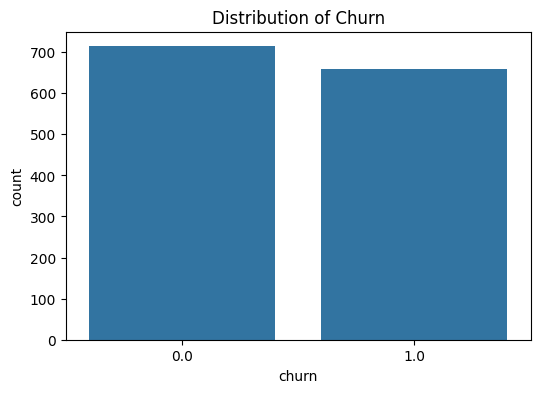

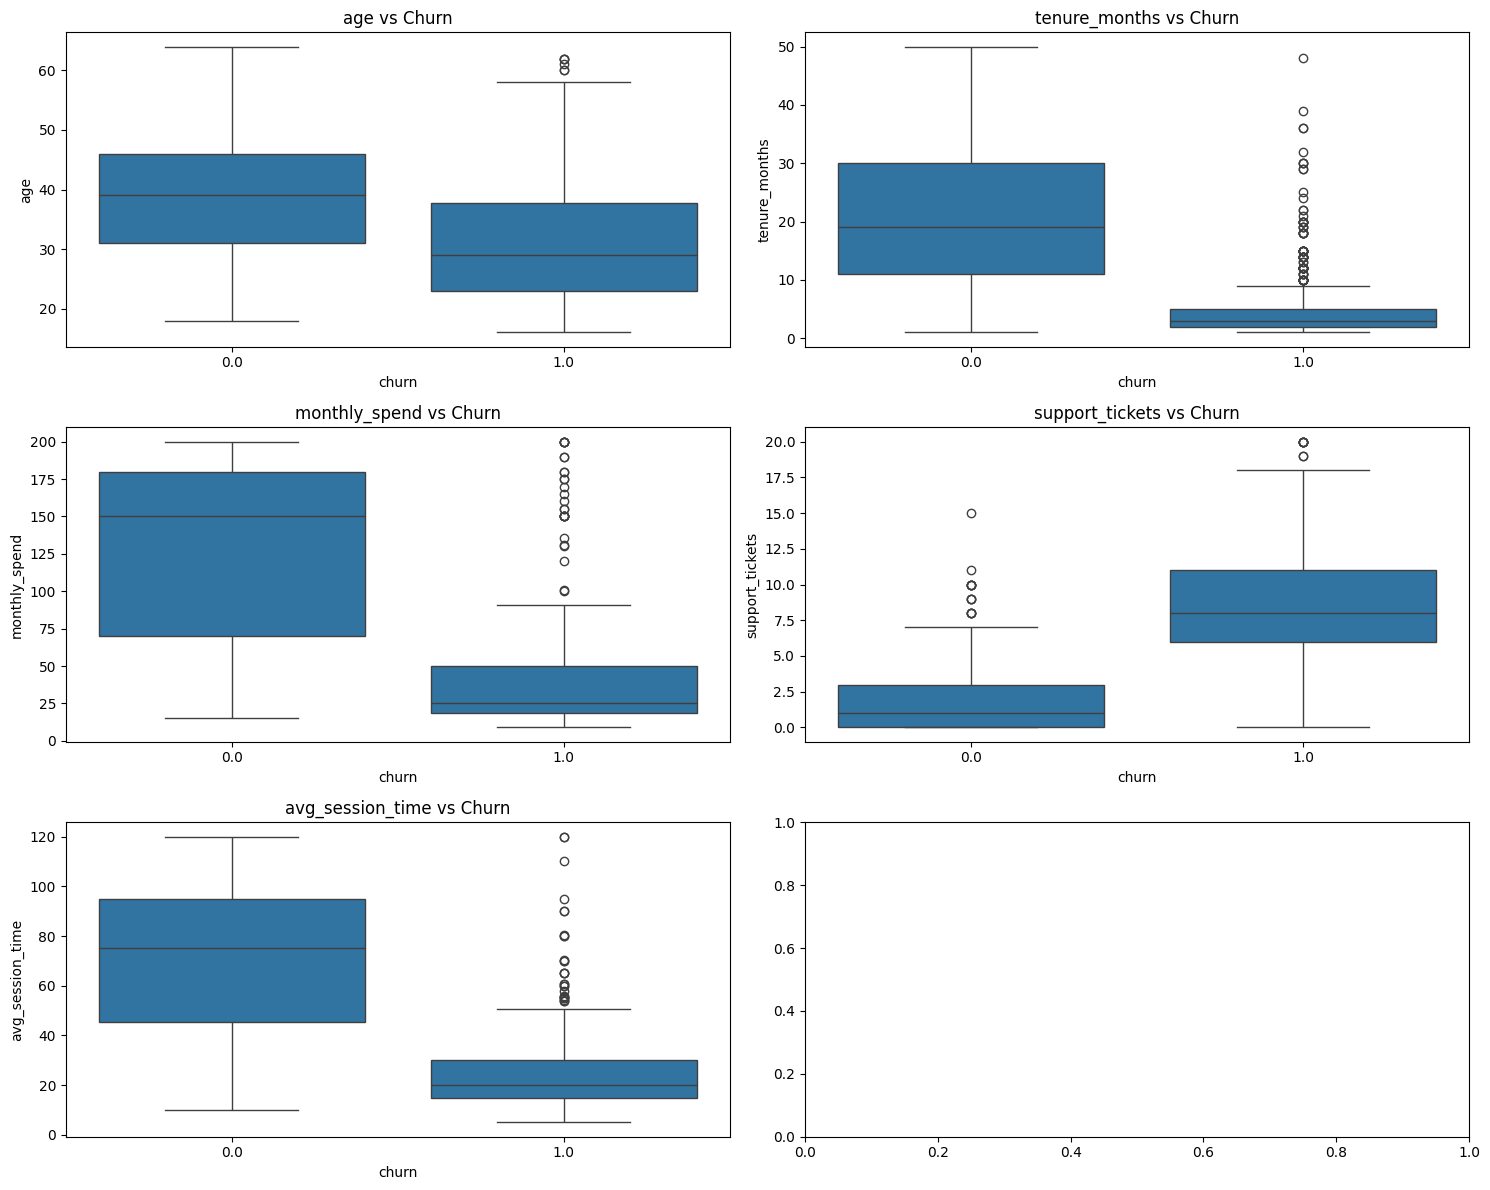

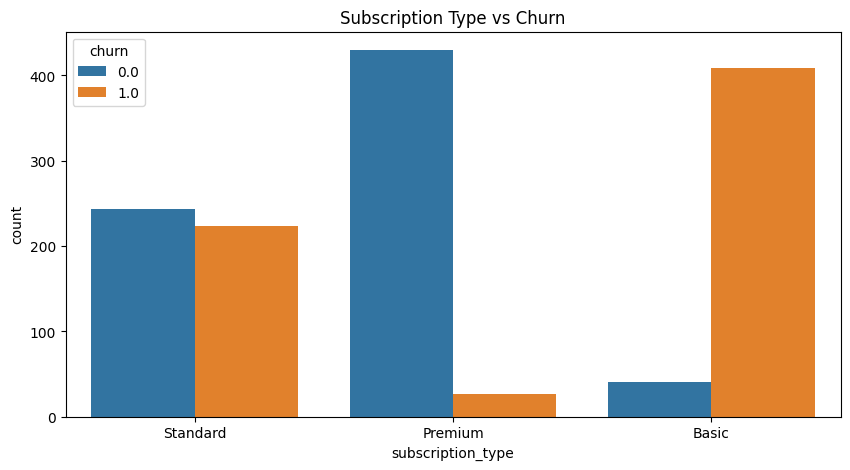

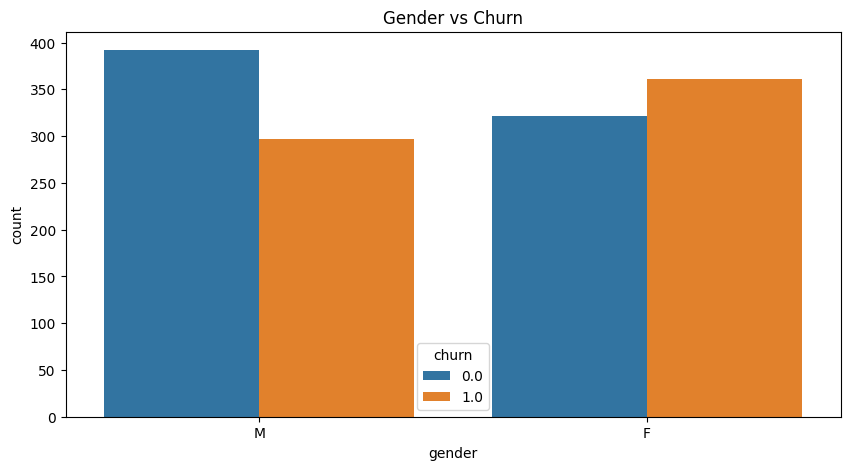

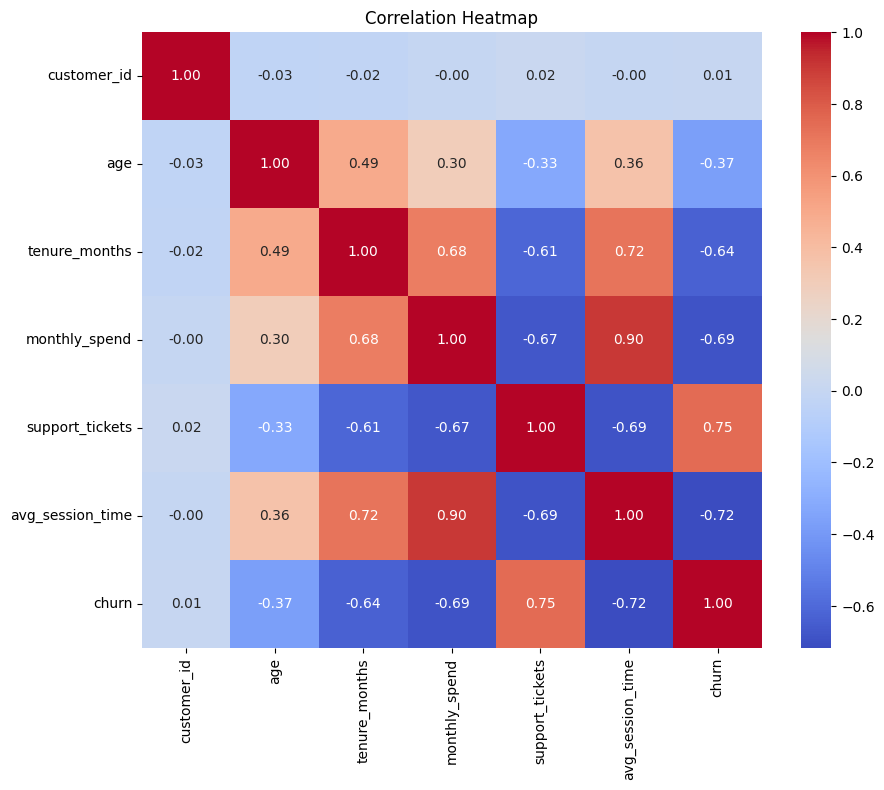

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Basic Information
info = df.info()
summary_stats = df.describe()

# 2. Check for missing values
missing_values = df.isnull().sum()

# 3. Churn Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='churn', data=df)
plt.title('Distribution of Churn')
plt.savefig('churn_distribution.png')

# 4. Numerical Features vs Churn
num_features = ['age', 'tenure_months', 'monthly_spend', 'support_tickets', 'avg_session_time']
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(num_features):
    sns.boxplot(x='churn', y=col, data=df, ax=axes[i])
    axes[i].set_title(f'{col} vs Churn')

plt.tight_layout()
plt.savefig('numerical_features_vs_churn.png')

# 5. Categorical Features vs Churn
plt.figure(figsize=(10, 5))
sns.countplot(x='subscription_type', hue='churn', data=df)
plt.title('Subscription Type vs Churn')
plt.savefig('subscription_vs_churn.png')

plt.figure(figsize=(10, 5))
sns.countplot(x='gender', hue='churn', data=df)
plt.title('Gender vs Churn')
plt.savefig('gender_vs_churn.png')

# 6. Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.select_dtypes(include=['number']).corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.savefig('correlation_heatmap.png')

print("Summary Stats:")
print(summary_stats)
print("\nMissing Values:")
print(missing_values)

In [8]:
print("--- Numerical Features by Churn (Mean) ---")
print(df.groupby("churn")[["age", "tenure_months", "monthly_spend", "support_tickets", "avg_session_time"]].mean())

print("\n--- Churn Rate by Subscription Type ---")
print(df.groupby("subscription_type")["churn"].mean())

print("\n--- Churn Rate by Gender ---")
print(df.groupby("gender")["churn"].mean())

print("\n--- Correlation with Churn ---")
print(df.select_dtypes(include=['number']).corr()["churn"].sort_values(ascending=False))

--- Numerical Features by Churn (Mean) ---
             age  tenure_months  monthly_spend  support_tickets  \
churn                                                             
0.0    39.053221      21.071429     128.705266         1.872549   
1.0    31.179331       4.743161      38.663480         8.641337   

       avg_session_time  
churn                    
0.0           70.638095  
1.0           23.993769  

--- Churn Rate by Subscription Type ---
subscription_type
Basic       0.910913
Premium     0.057018
Standard    0.477516
Name: churn, dtype: float64

--- Churn Rate by Gender ---
gender
F    0.528551
M    0.431060
Name: churn, dtype: float64

--- Correlation with Churn ---
churn               1.000000
support_tickets     0.750480
customer_id         0.006362
age                -0.370607
tenure_months      -0.637167
monthly_spend      -0.688751
avg_session_time   -0.717704
Name: churn, dtype: float64


#Model

In [9]:
#--------------------------------Neural Network ----------------------------------

print("======================================================================")
print("                          Neural Network                              ")
print("======================================================================")

# Create a copy of df for neural network training
df_nn = df.copy()

embedding_df = pd.DataFrame(df_nn['customer_feedback(vector)'].tolist(), index=df_nn.index)
embedding_df.columns = [f'embed_{i}' for i in range(embedding_df.shape[1])]

df_nn.drop(columns=['customer_feedback', 'customer_id', 'customer_feedback(vector)'], inplace=True)

df_nn = pd.concat([df_nn, embedding_df], axis=1)

# Feature Engineering (df_nn)
df_nn = pd.get_dummies(df_nn, columns=['gender', 'subscription_type'], drop_first=True)

scaler = StandardScaler()

num_cols = df_nn.select_dtypes(include=[np.number]).columns.tolist()
if 'churn' in num_cols:
    num_cols.remove('churn')

df_nn[num_cols] = scaler.fit_transform(df_nn[num_cols])

X_nn = df_nn.drop(columns=['churn'])
y_nn = df_nn['churn']

X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(X_nn, y_nn, test_size=0.2, random_state=42)

#Neural Network Builder
def build_neural_network(input_shape):
    """Builds and compiles a simple feed-forward neural network.

    Args:
        input_shape (tuple): Shape of the input features (e.g., (n_features,)).

    Returns:
        tf.keras.Model: A compiled Keras Sequential model.
    """
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=input_shape))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy')
    return model

#Train Neural Network
input_dim = X_train_nn.shape[1]
model_nn = build_neural_network((input_dim,))

# Fit the model
history_nn = model_nn.fit(
    X_train_nn,
    y_train_nn,
    epochs=20,
    batch_size=32,
    validation_data=(X_test_nn, y_test_nn)
)


# Evaluation

y_prob_nn = model_nn.predict(X_test_nn).ravel()
y_pred_nn = (y_prob_nn > 0.5).astype(int)

# Metrics
acc_nn = accuracy_score(y_test_nn, y_pred_nn)
f1_nn = f1_score(y_test_nn, y_pred_nn)
roc_auc_nn = roc_auc_score(y_test_nn, y_prob_nn)
rmse_nn = np.sqrt(mean_squared_error(y_test_nn, y_prob_nn))

print("\nNeural Network Metrics:")
print(f"Accuracy: {acc_nn:.4f}")
print(f"F1-Score: {f1_nn:.4f}")
print(f"ROC-AUC: {roc_auc_nn:.4f}")
print(f"RMSE (probabilities): {rmse_nn:.4f}")


# Prepare AI analysis prompt for Neural Network
accuracy_nn = acc_nn
analysis_prompt_nn = f"""
You are a Senior Data Scientist.

Model: Feed-forward Neural Network for customer churn prediction.

Metrics:
- Accuracy: {accuracy_nn:.4f}
- F1-Score: {f1_nn:.4f}
- ROC-AUC: {roc_auc_nn:.4f}
- RMSE (probabilities): {rmse_nn:.4f}

Questions:
1) Evaluate: Is this Neural Network performing well for a churn prediction task?
2) Compare: How would this likely compare to simple linear models (e.g., logistic regression)?
3) Insights: Given this model combines numerical features and `embed_` text-derived features, what business advantages does this more complex modeling approach provide?
"""

try:
    insights_nn = gemini_reply(analysis_prompt_nn)
    print("\n" + "="*50)
    print("=== NEURAL NETWORK AI INSIGHTS ===")
    print("="*50)
    print(insights_nn)
except Exception as e:
    print(f"Error calling Gemini for NN: {e}")

                          Neural Network                              


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 168ms/step - loss: 0.5298 - val_loss: 0.1970
Epoch 2/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2064 - val_loss: 0.1910
Epoch 3/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2003 - val_loss: 0.1846
Epoch 4/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1347 - val_loss: 0.1782
Epoch 5/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1287 - val_loss: 0.1797
Epoch 6/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1264 - val_loss: 0.1786
Epoch 7/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1026 - val_loss: 0.1739
Epoch 8/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0850 - val_loss: 0.1772
Epoch 9/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0990 - val_loss: 0.1926
Epoch 10/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0730 - val_loss: 0.2087
Epoch 11/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0775 - val_loss: 0.2235
Epoch 12/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0623 - 

In [10]:
#--------------------------------XGBoost ----------------------------------

print("======================================================================")
print("                          XGBoost                                     ")
print("======================================================================")

df['subscription_type'] = df['subscription_type'].map({
    'Basic': 1,
    'Standard':2,
    'Premium':3
})

df.drop(columns = ["customer_feedback","customer_id"], inplace=True)

df['gender'] = df['gender'].map({
    'M': 1,
    'F':0,
})


embedding_df = pd.DataFrame(df['customer_feedback(vector)'].tolist(), index=df.index)
embedding_df.columns = [f'embed_{i}' for i in range(embedding_df.shape[1])]

# Concatenate tabular features with the new embedding features
X = pd.concat([df.drop(columns=['churn', 'customer_feedback(vector)']), embedding_df], axis=1)
y = df['churn']

# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model_xgb = xgb.XGBClassifier(
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

model_xgb.fit(X_train, y_train)

# Predictions
y_pred = model_xgb.predict(X_test)
y_prob = model_xgb.predict_proba(X_test)[:, 1]

# Metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)
rmse = np.sqrt(mean_squared_error(y_test, y_prob)) # RMSE on probabilities

# Extract Feature Importance
feature_important = model_xgb.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

feature_importance_df = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
top_features = feature_importance_df.head(10).to_string()

print(f"Metrics Calculated:\nAccuracy: {accuracy}\nF1: {f1}\nROC-AUC: {roc_auc}\nRMSE: {rmse}")


# Define the Prompt
analysis_prompt = f"""
You are a Senior Data Scientist. I have trained an XGBoost model to predict customer churn.
Here are the model performance metrics and the top contributing features.

**Model Metrics:**
- Accuracy: {accuracy:.4f}
- F1-Score: {f1:.4f}
- ROC-AUC Score: {roc_auc:.4f}
- RMSE (on probabilities): {rmse:.4f}

**Top Features Driving Decisions:**
{top_features}

**Context:**
- Features starting with 'embed_' come from the vector embeddings of customer feedback text.
- Other features are standard demographic/usage data (age, monthly_spend, etc).

**Task:**
1. Summarize the model's performance. Is it good?
2. Interpret the feature importance. Does the text feedback (embedding features) play a bigger role than the structured data (like age/spend)?
3. Provide actionable business insights based on these findings.
"""


try:
    insights = gemini_reply(analysis_prompt)
    print("\n" + "="*50)
    print("GEMINI INSIGHTS REPORT")
    print("="*50)
    print(insights)
except Exception as e:
    print(f"Error calling Gemini: {e}")

                          XGBoost                                     


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [00:59:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Metrics Calculated:
Accuracy: 0.9418181818181818
F1: 0.9402985074626866
ROC-AUC: 0.988945308367714
RMSE: 0.21648349929458763

GEMINI INSIGHTS REPORT
Excellent work training this XGBoost model for churn prediction! Let's break down the results.

---

### 1. Summarize the model's performance. Is it good?

**Summary:**
This model demonstrates **exceptionally strong performance** across multiple key metrics for a binary classification task like churn prediction.

*   **Accuracy (0.9418):** A high overall correctness, indicating the model is correct 94.18% of the time.
*   **F1-Score (0.9403):** This is particularly important for churn, which is often an imbalanced dataset (fewer churners than non-churners). A high F1-Score suggests a good balance between precision (minimizing false positives, i.e., not incorrectly flagging non-churners) and recall (minimizing false negatives, i.e., catching most actual churners). This is a great sign.
*   **ROC-AUC Score (0.9889):** This is the **most impr

In [11]:
#-------------------------Logistic Regression--------------------------------

print("======================================================================")
print("                          Logistic Regression                         ")
print("======================================================================")

from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

# Expand embedding column
embedding_dim = len(df["customer_feedback(vector)"].iloc[0])

embeddings_df = pd.DataFrame(
    df["customer_feedback(vector)"].tolist(),
    index=df.index,
    columns=[f"emb_{i}" for i in range(embedding_dim)]
)

# Combine embeddings back
df = pd.concat([df, embeddings_df], axis=1)

X = df.drop(columns=["churn", "customer_id"], errors='ignore')
y = df["churn"]

numeric_features = [
    "age",
    "tenure_months",
    "monthly_spend",
    "support_tickets",
    "avg_session_time"
]

categorical_features = [
    "gender",
    "subscription_type"
]

embedding_features = [col for col in X.columns if col.startswith("emb_")]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(drop="first"), categorical_features),
        ("emb", StandardScaler(), embedding_features)
    ]
)

log_reg = LogisticRegression(
    penalty="l2",
    solver="saga",
    max_iter=5000,
    class_weight="balanced",
    n_jobs=-1
)

pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", log_reg)
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

metrics = {
    "accuracy": accuracy_score(y_test, y_pred),
    "f1_score": f1_score(y_test, y_pred),
    "roc_auc": roc_auc_score(y_test, y_prob),
    "rmse": np.sqrt(mean_squared_error(y_test, y_prob))
}

feature_names = pipeline.named_steps["preprocessor"].get_feature_names_out()
coefficients = pipeline.named_steps["classifier"].coef_[0]

importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefficients,
    "Abs_Coefficient": np.abs(coefficients)
}).sort_values(by="Abs_Coefficient", ascending=False)

# Separate business features from embeddings
business_features = importance_df[
    ~importance_df["Feature"].str.contains("emb_")
]

print(business_features)

genai.configure(api_key=GOOGLE_API_KEY)

llm = genai.GenerativeModel("gemini-2.5-flash")

prompt = f"""
You are an expert data scientist evaluating a customer churn prediction model.

MODEL:
- Logistic Regression with L2 regularization
- Sentence-BERT embeddings used for customer feedback
- Binary classification (churn)

EVALUATION METRICS:
Accuracy: {metrics['accuracy']:.4f}
F1-score: {metrics['f1_score']:.4f}
ROC-AUC: {metrics['roc_auc']:.4f}
RMSE: {metrics['rmse']:.4f}

TOP FEATURE COEFFICIENTS (Logistic Regression):
{business_features}

TASK:
1. Summarise the model performance using the provided metrics.
2. Interpret what the results imply about churn prediction quality.
3. Explain how the top features influence churn.
4. Comment on the role of customer feedback embeddings.
5. Provide business and analytical insights.

Write in a formal, academic tone suitable for a final-year project or research report.
"""

response = llm.generate_content(prompt)

print(response.text)

                          Logistic Regression                         
              precision    recall  f1-score   support

         0.0       0.89      0.92      0.91       143
         1.0       0.91      0.88      0.90       132

    accuracy                           0.90       275
   macro avg       0.90      0.90      0.90       275
weighted avg       0.90      0.90      0.90       275

ROC-AUC: 0.9715511760966307
Accuracy: 0.9018181818181819
F1 Score: 0.8957528957528957
                    Feature  Coefficient  Abs_Coefficient
3      num__support_tickets     3.111379         3.111379
1        num__tenure_months    -1.047529         1.047529
4     num__avg_session_time    -1.039858         1.039858
5             cat__gender_1     0.495913         0.495913
0                  num__age    -0.432898         0.432898
2        num__monthly_spend    -0.272539         0.272539
6  cat__subscription_type_2     0.209727         0.209727
7  cat__subscription_type_3    -0.207634         0.2

In [12]:
#-------------------------Decision Tree Model-------------------------------------

print("======================================================================")
print("                          Decision Tree                               ")
print("======================================================================")


print("\n" + "="*50)
print("Start of the decision tree model code")
print("\n" + "="*50)

# 1. PREPARE THE FEATURES (X) AND TARGET (y)

# A. Handle the Embeddings
# We need to expand the list/array in "customer_feedback(vector)" into separate columns
embedding_df = pd.DataFrame(df["customer_feedback(vector)"].tolist(), index=df.index)
# Rename these new columns to something like embed_0, embed_1, etc.
embedding_df.columns = [f"embed_{i}" for i in range(embedding_df.shape[1])]

# B. Handle Categorical Data (One-Hot Encoding)
# Select numerical and categorical features
features = df[['age', 'gender', 'subscription_type', 'tenure_months',
               'monthly_spend', 'support_tickets', 'avg_session_time']]

# Convert 'gender' and 'subscription_type' to numbers (0s and 1s)
features_encoded = pd.get_dummies(features, columns=['gender', 'subscription_type'], drop_first=True)

# C. Combine everything into X
# Join the numerical/categorical features with the embedding features
X = pd.concat([features_encoded, embedding_df], axis=1)

# D. Define Target
y = df['churn']

# 2. SPLIT DATA (Training and Testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. BUILD THE DECISION TREE MODEL
dt_model = DecisionTreeClassifier(random_state=42, max_depth=5) # max_depth limits tree size to prevent overfitting
dt_model.fit(X_train, y_train)

# 4. PREDICT AND EVALUATE
y_pred = dt_model.predict(X_test)

y_prob = dt_model.predict_proba(X_test)[:, 1] # Probability for ROC-AUC

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)
rmse = np.sqrt(mean_squared_error(y_test, y_prob)) # RMSE based on probabilities
report = classification_report(y_test, y_pred)

print(f"Accuracy: {acc:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC:  {roc_auc:.4f}")
print(f"RMSE:     {rmse:.4f}")
print("-" * 30)



##FEATURE IMPORTANCE EXTRACTION

feature_names = X.columns
importances = dt_model.feature_importances_
# Get indices of top 10 features
indices = np.argsort(importances)[::-1][:10]

top_features_list = []
for i in indices:
    feat_name = feature_names[i]
    score = importances[i]
    top_features_list.append(f"{feat_name}: {score:.4f}")

top_features_str = "\n".join(top_features_list)
print("Top 10 Features Driving Churn:\n" + top_features_str)


##GEMINI LLM INTEGRATION
def get_gemini_analysis(api_key, accuracy, roc, top_feats):
    if api_key == "YOUR_GEMINI_API_KEY_HERE":
        print("\n[!] Please insert your Gemini API Key to get the LLM analysis.")
        return

    try:
        genai.configure(api_key=api_key)
        # using gemini-1.5-flash because it is fast and cheap/free tier eligible
        llm_model = genai.GenerativeModel('gemini-2.5-flash')

        prompt = f"""
        You are an expert Data Scientist. I have trained a Customer Churn Prediction model (Decision Tree).

        Here are the evaluation metrics:
        - Accuracy: {accuracy:.2f}
        - ROC-AUC Score: {roc:.2f}

        Here are the top 10 most important features driving the model:
        {top_feats}

        Note: Features starting with 'embed_' refer to dimensions in the customer feedback text vector (semantic meaning of their review).
        Features like 'support_tickets' or 'monthly_spend' are numerical.

        Please provide a brief report:
        1. Summarize the model's performance (is it good based on ROC-AUC?).
        2. Interpret the important features. What is driving churn the most?
        3. Provide 2 actionable business insights based on these findings.
        """

        print("\n" + "="*40)
        print("GENERATING INSIGHTS WITH GEMINI...")
        print("="*40)

        response = llm_model.generate_content(prompt)
        print(response.text)

    except Exception as e:
        print(f"Error calling Gemini API: {e}")

# Run the Gemini Analysis
get_gemini_analysis(GOOGLE_API_KEY, acc, roc_auc, top_features_str)

                          Decision Tree                               

Start of the decision tree model code

Accuracy: 0.8982
F1-Score: 0.8986
ROC-AUC:  0.8774
RMSE:     0.3120
------------------------------
Top 10 Features Driving Churn:
support_tickets: 0.7250
tenure_months: 0.0665
avg_session_time: 0.0332
monthly_spend: 0.0211
embed_176: 0.0189
age: 0.0160
embed_218: 0.0150
embed_110: 0.0125
embed_167: 0.0122
embed_154: 0.0104

GENERATING INSIGHTS WITH GEMINI...
Here's a brief report on your Customer Churn Prediction model:

---

### Customer Churn Prediction Model Report

**1. Model Performance Summary**

Your Customer Churn Prediction model demonstrates **strong performance**.
*   **Accuracy (0.90):** The model correctly predicts churn or non-churn for 90% of customers, which is a good baseline indicator.
*   **ROC-AUC Score (0.88):** This is an excellent score, especially for a churn prediction model. An ROC-AUC of 0.88 indicates that the model has a high capacity to distinguis

                          Random Forest                               
Generating Embeddings for Random Forest...
Training Random Forest...
Random Forest Metrics:
Accuracy: 0.9455
F1: 0.9451
ROC-AUC: 0.9887
RMSE: 0.2402

GEMINI INSIGHTS REPORT (RANDOM FOREST)
Okay, this is an excellent set of results. Let's break down the model's performance and extract some actionable insights.

As a Senior Data Scientist, here's my analysis:

---

### **1. Summary of Random Forest Model Performance**

The Random Forest model demonstrates **exceptionally strong predictive performance** for customer churn.

*   **Accuracy (0.9455):** A high accuracy means the model correctly predicts churn (or non-churn) for approximately 94.55% of your customer base. This indicates a very reliable overall classification.
*   **F1-Score (0.9451):** The F1-Score is particularly important for churn prediction, as churn datasets are often imbalanced (fewer churners than non-churners). A high F1-Score (above 0.94) indicate

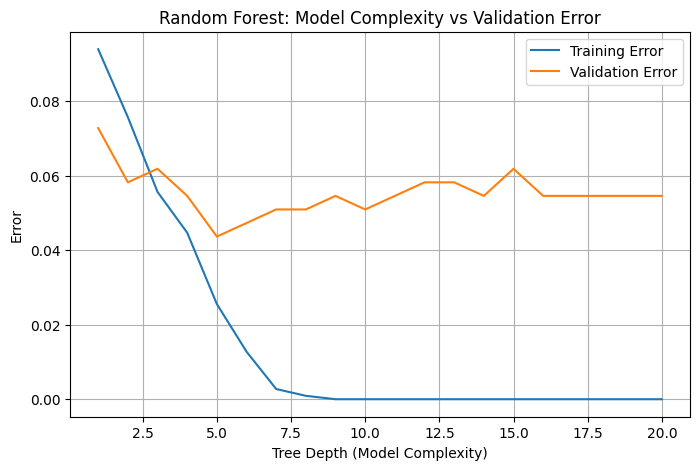

In [18]:
#--------------------------------Random Forest ----------------------------------

print("======================================================================")
print("                          Random Forest                               ")
print("======================================================================")


# 1. IMPORT NECESSARY LIBRARIES FOR THIS SECTION
from sklearn.ensemble import RandomForestClassifier

# 2. RELOAD DATA
df_rf = pd.read_csv("clean_customer_churn_dataset.csv")

# 3. VECTORIZATION
print("Generating Embeddings for Random Forest...")
df_rf["customer_feedback(vector)"] = df_rf["customer_feedback"].apply(get_embedding)

# 4. PREPROCESSING
df_rf['subscription_type'] = df_rf['subscription_type'].map({'Basic': 1, 'Standard': 2, 'Premium': 3})
df_rf['gender'] = df_rf['gender'].map({'M': 1, 'F': 0})

# Drop columns not needed for training
df_rf.drop(columns=["customer_feedback", "customer_id"], inplace=True)

# Expand embeddings into separate columns
embedding_df_rf = pd.DataFrame(df_rf['customer_feedback(vector)'].tolist(), index=df_rf.index)
embedding_df_rf.columns = [f'embed_{i}' for i in range(embedding_df_rf.shape[1])]

# Concatenate tabular features with the new embedding features
X_rf = pd.concat([df_rf.drop(columns=['churn', 'customer_feedback(vector)']), embedding_df_rf], axis=1)
y_rf = df_rf['churn']

# 5. SPLIT DATA
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y_rf, test_size=0.2, random_state=42)

# 6. INITIALIZE AND TRAIN RANDOM FOREST
print("Training Random Forest...")
model_rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced'
)
model_rf.fit(X_train_rf, y_train_rf)

# 7. PREDICTIONS & METRICS
y_pred_rf = model_rf.predict(X_test_rf)
y_prob_rf = model_rf.predict_proba(X_test_rf)[:, 1]

accuracy_rf = accuracy_score(y_test_rf, y_pred_rf)
f1_rf = f1_score(y_test_rf, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test_rf, y_prob_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test_rf, y_prob_rf))

print(f"Random Forest Metrics:\nAccuracy: {accuracy_rf:.4f}\nF1: {f1_rf:.4f}\nROC-AUC: {roc_auc_rf:.4f}\nRMSE: {rmse_rf:.4f}")

# 8. FEATURE IMPORTANCE
importances_rf = model_rf.feature_importances_
feature_importance_rf = pd.DataFrame(
    data=importances_rf,
    index=X_rf.columns,
    columns=["score"]
).sort_values(by="score", ascending=False)

top_features_rf = feature_importance_rf.head(10).to_string()

# 9. GEMINI AI ANALYSIS (Random Forest Specific)
def get_rf_gemini_analysis(api_key, accuracy, f1, roc, top_feats):
    if not api_key:
        print("\n[!] Gemini API Key missing.")
        return

    try:
        genai.configure(api_key=api_key)
        # Using the same model version as the rest of the file
        llm_model = genai.GenerativeModel('gemini-2.5-flash')

        prompt = f"""
        You are a Senior Data Scientist. I have trained a Random Forest model to predict customer churn.
        Here are the model performance metrics and the top contributing features.

        **Model Metrics:**
        - Accuracy: {accuracy:.4f}
        - F1-Score: {f1:.4f}
        - ROC-AUC Score: {roc:.4f}

        **Top Features Driving Decisions:**
        {top_feats}

        **Task:**
        1. Summarize the Random Forest model's performance.
        2. Compare the feature importance: Do the embedding features (text sentiment) matter more than structured data?
        3. Provide actionable business insights.
        """

        print("\n" + "="*50)
        print("GEMINI INSIGHTS REPORT (RANDOM FOREST)")
        print("="*50)

        response = llm_model.generate_content(prompt)
        print(response.text)

    except Exception as e:
        print(f"Error calling Gemini for RF: {e}")

# Run the analysis using the global API key defined at the top of the file
get_rf_gemini_analysis(GOOGLE_API_KEY, accuracy_rf, f1_rf, roc_auc_rf, top_features_rf)


# 10. MODEL COMPLEXITY VS VALIDATION ERROR (RANDOM FOREST)

from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

max_depth_values = range(1, 21)

train_errors = []
val_errors = []

for depth in max_depth_values:
    rf_temp = RandomForestClassifier(
        n_estimators=100,
        max_depth=depth,
        random_state=42,
        class_weight='balanced'
    )

    rf_temp.fit(X_train_rf, y_train_rf)

    # Training predictions
    train_pred = rf_temp.predict(X_train_rf)
    train_error = 1 - accuracy_score(y_train_rf, train_pred)

    # Validation predictions
    val_pred = rf_temp.predict(X_test_rf)
    val_error = 1 - accuracy_score(y_test_rf, val_pred)

    train_errors.append(train_error)
    val_errors.append(val_error)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(max_depth_values, train_errors, label="Training Error")
plt.plot(max_depth_values, val_errors, label="Validation Error")
plt.xlabel("Tree Depth (Model Complexity)")
plt.ylabel("Error")
plt.title("Random Forest: Model Complexity vs Validation Error")
plt.legend()
plt.grid(True)
plt.show()


/tmp/ipython-input-3255452244.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_importances, y=top_features, palette="viridis")


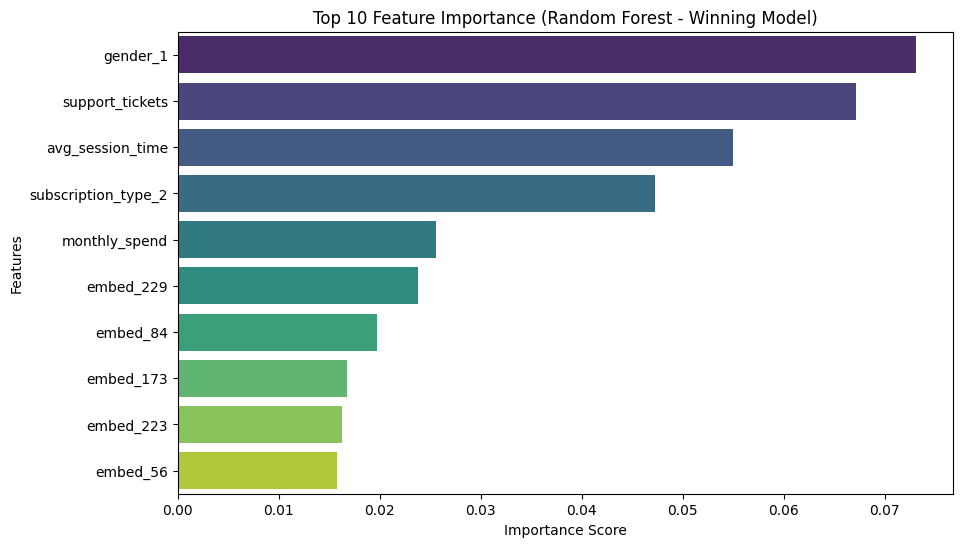

Top 10 Features:
gender_1: 0.0731
support_tickets: 0.0672
avg_session_time: 0.0550
subscription_type_2: 0.0473
monthly_spend: 0.0255
embed_229: 0.0238
embed_84: 0.0197
embed_173: 0.0167
embed_223: 0.0162
embed_56: 0.0158


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# 1. Get Feature Importances from the trained Random Forest model
# Note: Ensure your model variable is named correctly (e.g., rf_model, model_rf, etc.)
# Assuming the model variable is named 'rf_model' or similar.
# If your variable is named 'model', change 'rf_model' to 'model' below.

importances = model_rf.feature_importances_ # CHANGE 'rf_model' if your variable name is different
feature_names = X_train.columns
indices = np.argsort(importances)[::-1]

# 2. Select Top 10 Features
top_n = 10
top_indices = indices[:top_n]
top_features = [feature_names[i] for i in top_indices]
top_importances = importances[top_indices]

# 3. Plot the Bar Chart
plt.figure(figsize=(10, 6))
sns.barplot(x=top_importances, y=top_features, palette="viridis")
plt.title('Top 10 Feature Importance (Random Forest - Winning Model)')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

# 4. Print the actual values for your report text
print("Top 10 Features:")
for f, imp in zip(top_features, top_importances):
    print(f"{f}: {imp:.4f}")